In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee


In [2]:
import models
import experiment as exp
import plots
import utils

In [3]:
from importlib import reload
_ = reload(models)
_ = reload(exp)
_ = reload(plots)
_ = reload(utils)


## Example:

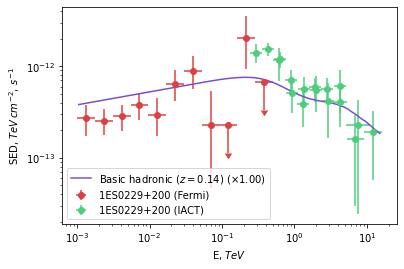

In [4]:
obj = exp.Object.by_name('1ES0229+200')
model = models.BasicHadronicModelSED.at_z(obj.z)
model.normalize_to_experimental_sed(obj.seds[0])

fig, ax = plt.subplots(figsize=(6, 4))

obj.plot(ax)
model.plot(ax, E_min=obj.E_min, E_max=obj.E_max)

ax.legend()
plt.show()

# Joint posterior for all objects

In [6]:
object_models = []
for obj in exp.all_objects:
    obj_model = models.BasicHadronicModelSED.at_z(obj.z)
    obj_model.normalize_to_experimental_sed(obj.seds[0])
    object_models.append(obj_model)

object_logposteriors = [
    obj.get_joint_logposterior(model) for obj, model in zip(exp.all_objects, object_models)
]

def get_all_objects_logp_sum(logprob_funcs, n_objects: int):
    def logprob(theta):
        # E_factors_1 = theta[:n_objects]
        E_factors_2 = theta[n_objects:2*n_objects]
        normalizations = theta[2*n_objects:]
        logp = 0
        for obj_logprob, normalization, E_factor_1, E_factor_2 in zip(
            logprob_funcs, normalizations, E_factors_1, E_factors_2
        ):
            logp += obj_logprob((normalization,), (E_factor_1, E_factor_2))
            if np.isinf(logp):
                return -np.inf
        return logp
    return logprob

In [16]:
n_walkers = 1024
# E_factor_1, E_factor_2, normalization for each
n_objects = len(exp.all_objects)
n_dim = 3 * n_objects
sampler = emcee.EnsembleSampler(n_walkers, n_dim, get_all_objects_logp_sum(object_logposteriors, n_objects))

In [17]:
theta_estimation = np.ones(shape=(n_dim,), dtype=float)
theta_starting_point_log_sigmas = [0.1, 0.1] * len(exp.all_objects) + [0.5] * len(exp.all_objects)

starting_points = np.tile(theta_estimation, (n_walkers, 1))
for i, sigma in enumerate(theta_starting_point_log_sigmas):
    starting_points[:, i] = np.exp(np.random.normal(loc=0, scale=np.log(1 + sigma), size=(n_walkers,)))

In [18]:
_ = sampler.run_mcmc(starting_points, 10000, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/kbhmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [07:36<00:00, 21.90it/s]


In [19]:
np.mean(sampler.acceptance_fraction)

0.12844462890625

# Sampling results

In [20]:
taus = sampler.get_autocorr_time(quiet=True)
if np.all(np.isnan(taus)):
    print('unable to calculate tau, setting manually')
    tau = 300
else:
    tau = int(np.max(taus[np.isfinite(taus)]))

print(f'tau = {tau}')

/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/kbhmenv/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
unable to calculate tau, setting manually
tau = 300


In [21]:
sample = sampler.get_chain(flat=True, thin=tau, discard=tau * 10)

print(sample.shape)

(23552, 15)


In [22]:
import corner

param_names = (
    ['$\\delta_{{Fermi}}$', '$\\delta_{{IACT}}$']
    + [f'{obj.name}\nk' for obj in exp.all_objects]
)

# figure = corner.corner(sample, labels=param_names, show_titles=True, bins=50)
# figure = corner.corner(sample, bins=50)

In [25]:
object_loglikes = [
    obj.get_joint_loglike(model)
    for obj, model in zip(exp.all_objects, object_models)
]

theta_maxloglike = utils.max_loglike_point(
    sample, get_all_objects_logp_sum(object_loglikes, n_objects), progress=True,
)

E_factors_1 = theta_maxloglike[:n_objects]
E_factors_2 = theta_maxloglike[n_objects:2*n_objects]
normalizations = theta_maxloglike[2*n_objects:]

100%|██████████| 23552/23552 [00:05<00:00, 4001.58it/s] 


In [26]:
objects_shifted = [
    obj.with_E_factors(dE_fermi, dE_Iact)
    for obj, dE_fermi, dE_Iact in zip(exp.all_objects, E_factors_1, E_factors_2)
]

for model, norm in zip(object_models, normalizations):
    model.set_parameters(normalization=norm)

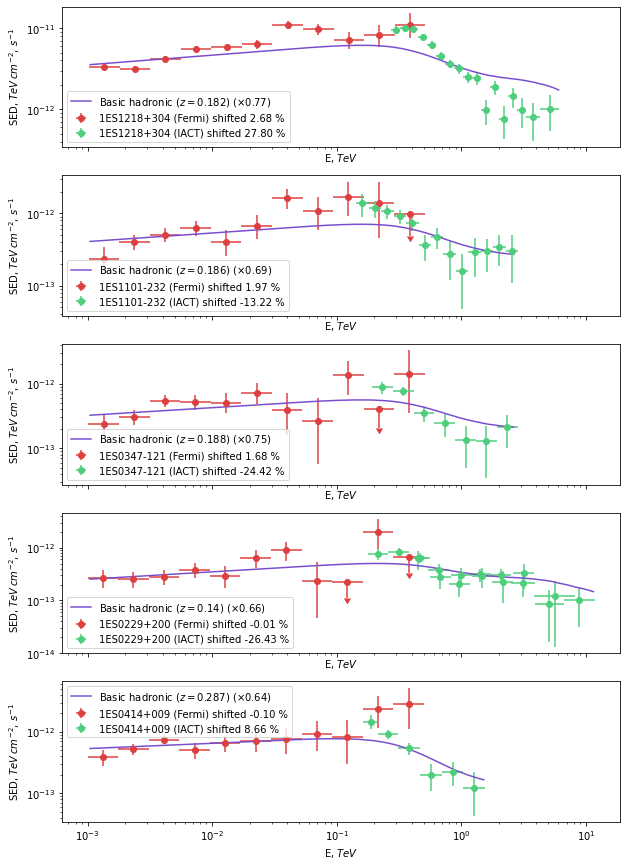

In [27]:
_ = reload(plots)
fig, axes = plots.plot_objects_with_model(objects_shifted, object_models)

fig.savefig('basic-hadronic-bestfit-independent-E-shifts.png')

In [30]:
utils.AIC(k=3 * len(exp.all_objects), sample=sample, loglike=get_all_objects_logp_sum(object_loglikes, n_objects))

409.1872496599925